In [1]:
# ! curl -O https://s3-us-west-2.amazonaws.com/telemanom/data.zip && unzip data.zip && rm data.zip

In [1]:
import ast
import os
import logging
import pickle
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.m2ad import M2AD

LOGGER = logging.Logger('notebook')

In [2]:
import os
import json

def load_data(signal, columns=25, start=None):
    train = pd.DataFrame(np.load(f'data/train/{signal}.npy'), columns=map(str, range(columns)))
    test = pd.DataFrame(np.load(f'data/test/{signal}.npy'), columns=map(str, range(columns)))
    
    start = start or pd.to_datetime('2010-01-01')
    
    train['time'] = [start + timedelta(hours=i) for i in range(len(train))]
    test['time'] = [start + timedelta(hours=i) for i in range(len(train), len(train) + len(test))]

    return train, test

labels_data = list()

CSV_URL = 'https://github.com/khundman/telemanom/raw/master/labeled_anomalies.csv'

df = pd.read_csv(CSV_URL)
df.head()

category = {}

for _, row in df.iterrows():
    signal = row.chan_id
    dataset = row.spacecraft
    category[signal] = dataset
    
    if dataset == 'MSL':
        columns = 55
    else:
        columns = 25
    
    train, test = load_data(signal, columns=columns)
    
    for start, end in json.loads(row.anomaly_sequences):
        start_ts = test.iloc[start].time
        end_ts = test.iloc[end].time
    
        labels_data.append({
            'signal': signal,
            'dataset': dataset,
            'start': start_ts,
            'end': end_ts
        })
    
labels = pd.DataFrame(labels_data)
labels.head()

,signal,dataset,start,end
0,P-1,SMAP,2010-07-29 05:00:00,2010-08-06 13:00:00
1,P-1,SMAP,2010-11-05 16:00:00,2010-11-18 12:00:00
2,P-1,SMAP,2010-09-25 03:00:00,2010-10-05 03:00:00
3,S-1,SMAP,2010-12-05 06:00:00,2010-12-23 21:00:00
4,E-1,SMAP,2010-11-25 08:00:00,2010-11-26 14:00:00


In [3]:
train, test = load_data('S-1', columns=25)

In [4]:
train

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,time
0,-0.366359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-01 00:00:00
1,-0.394108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-01 01:00:00
2,0.403625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-01 02:00:00
3,-0.362759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-01 03:00:00
4,-0.370746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2813,-0.365308,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-04-28 05:00:00
2814,1.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-04-28 06:00:00
2815,-0.341357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-04-28 07:00:00
2816,-0.392546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010-04-28 08:00:00


In [ ]:
folder = 'cache'
os.makedirs(folder, exists=True)

In [ ]:
anomalies = list()
visuals = dict()

pbar = tqdm(category.items())
    
for signal, dataset in pbar:
    pbar.set_postfix({'signal': signal})
        
    if dataset == 'MSL':
        columns = 55
    else:
        columns = 25

    train, test = load_data(signal, columns=columns)
    covariates = [str(i) for i in range(1, columns)]
    
    model = M2AD(
        dataset=dataset,
        entity=signal,
        epochs=30,
        window_size=100,
        n_components=1,
        sensors=['0']
        covariates=covariates,
        verbose=False,
        error_name='area',
        feature_range=(0, 1)
    )
    
    try:
        model.fit(train)
    
        anom, viz = model.detect(test, debug=True)
        anomalies.append(anom)
        visuals[signal] = viz

        with open(os.path.join(folder, f'{dataset}_{signal}.pkl'), 'wb') as f:
            pickle.dump(viz, f)

    except Exception as ex:
        LOGGER.exception(f'Exception scoring on signal {signal}, error {ex}.')

 47%|████▋     | 38/81 [37:24<41:32, 57.96s/it, signal=G-4]   

In [35]:
allanomalies = pd.concat(anomalies)
allanomalies.shape

(128199, 3)

In [36]:
def group_anomalies(df, anomaly_column='anomaly', days=5):
    anomalies = list()
    keys = list(df.columns)
    keys.remove(anomaly_column)
    columns = keys + ['start', 'end']

    if len(df) == 0:
        return pd.DataFrame([], columns=columns)

    for name, group in df.groupby(keys):
        dates = group[anomaly_column]
        dates = sorted(dates)
        intervals = [(*name, dates[0], dates[0] + timedelta(days=days))]
        for date in dates[1:]:
            prev_interval = intervals[-1][-2:]
            if prev_interval[0] <= date <= prev_interval[1]:
                intervals[-1] = (*intervals[-1][:-1], date + timedelta(days=days))
                continue
            
            intervals.append((*name, date, date + timedelta(days=days)))

        anomalies.append(
            pd.DataFrame(
                intervals, columns=columns
            )
        )

    return pd.concat(anomalies)

allanomalies = pd.concat(anomalies)
allanomalies = group_anomalies(allanomalies, days=15)

In [37]:
allanomalies.head()

,site,asset_id,start,end
0,MSL,C-1,2010-04-14 14:00:00,2010-05-14 00:00:00
0,MSL,C-2,2010-02-10 14:00:00,2010-05-09 06:00:00
0,MSL,D-14,2010-07-21 15:00:00,2010-10-05 11:00:00
0,MSL,D-15,2010-06-01 15:00:00,2010-07-11 07:00:00
0,MSL,F-4,2010-04-24 06:00:00,2010-05-10 03:00:00


In [38]:
def get_dataset(signal):
    mapping = labels.set_index('signal')['dataset'].to_dict()
    return mapping[signal]

def overlap(p, truth):
    flag = False
    index = list()
    for i, t in truth.iterrows():
        if (p.start <= t.end) and (p.end >= t.start):
            flag = True
            index.append(i)

    if flag:
        return index
        
    return flag
            
def cm(pred, truth):
    correct = 0
    incorrect = 0
    
    index = list()
    for _, p in pred.iterrows():
        flag = overlap(p, truth)
        if isinstance(flag, list):
            index.extend(flag)
            correct += len(flag)

        else:
            incorrect += 1

    remaining = len(truth) - len(truth.loc[index])

    return correct, incorrect, remaining
    
def get_scores(pred, ground_truth):
    key = ['site', 'asset_id']
    
    scores = {}
    scores['MSL'] = {'true_positive': 0, 'false_positive': 0, 'false_negative': 0}
    scores['SMAP'] = {'true_positive': 0, 'false_positive': 0, 'false_negative': 0}

    siginals = set(ground_truth['signal'])
    
    for signal in signals:
        site = get_dataset(signal)

        detect = pred[pred['asset_id'] == signal]
        truth = ground_truth[ground_truth['signal'] == signal]
        tp, fp, fn = cm(detect, truth)
        
        scores[site]['true_positive'] += tp
        scores[site]['false_positive'] += fp
        scores[site]['false_negative'] += fn

    return scores

In [39]:
scores = get_scores(allanomalies, labels)
scores

{'MSL': {'true_positive': 31, 'false_positive': 21, 'false_negative': 5},
 'SMAP': {'true_positive': 60, 'false_positive': 65, 'false_negative': 9}}

In [40]:
allanomalies.groupby('site').count()

,asset_id,start,end
site,,,
MSL,49,49,49
SMAP,118,118,118


In [41]:
labels.groupby('dataset').count()

,signal,start,end
dataset,,,
MSL,36,36,36
SMAP,69,69,69


In [42]:
results = pd.DataFrame(scores).T
results

,true_positive,false_positive,false_negative
MSL,31,21,5
SMAP,60,65,9


In [43]:
results = results.eval('precision = true_positive / (true_positive + false_positive)')
results = results.eval('recall = true_positive / (true_positive + false_negative)')
results = results.eval('f1 = 2 * precision * recall / (precision + recall)')

results

,true_positive,false_positive,false_negative,precision,recall,f1
MSL,31,21,5,0.596154,0.861111,0.704545
SMAP,60,65,9,0.480000,0.869565,0.618557


In [4]:
# debug D-13

train, test = load_data('D-13')
columns = 55 if get_dataset('D-13') == 'MSL' else 25
covariates = [str(i) for i in range(1, columns)]

pipeline = LSTMGMMPipeline(
    site=dataset,
    asset_id='D-13',
    epochs=5,
    window_size=120,
    n_components=1,
    covariates=covariates,
    verbose=True,
    smoothing_window=10,
)

pipeline.fit(train)

Epoch 1/30: train loss  0.2247 | val loss  0.0103.
Epoch 2/30: train loss  0.0015 | val loss  0.0001.
Epoch 3/30: train loss  0.0001 | val loss  0.0000.
Epoch 4/30: train loss  0.0000 | val loss  0.0000.
Epoch 5/30: train loss  0.0000 | val loss  0.0000.
Epoch 6/30: train loss  0.0000 | val loss  0.0000.
Epoch 7/30: train loss  0.0000 | val loss  0.0000.
Epoch 8/30: train loss  0.0000 | val loss  0.0000.
Epoch 9/30: train loss  0.0000 | val loss  0.0000.
Epoch 10/30: train loss  0.0000 | val loss  0.0000.
Epoch 11/30: train loss  0.0000 | val loss  0.0000.
Epoch 12/30: train loss  0.0000 | val loss  0.0000.
Epoch 13/30: train loss  0.0000 | val loss  0.0000.
Epoch 14/30: train loss  0.0000 | val loss  0.0000.
Epoch 15/30: train loss  0.0000 | val loss  0.0000.
Early stopping at epoch: 15


No variance found between p-values (0.0).


In [8]:
anom, viz = pipeline.detect(test, debug=True)
group_anomalies(anom)

,site,asset_id,start,end
0,MSL,D-13,2010-03-09 22:00:00,2010-04-25 17:00:00
1,MSL,D-13,2010-10-02 06:00:00,2011-01-22 08:00:00


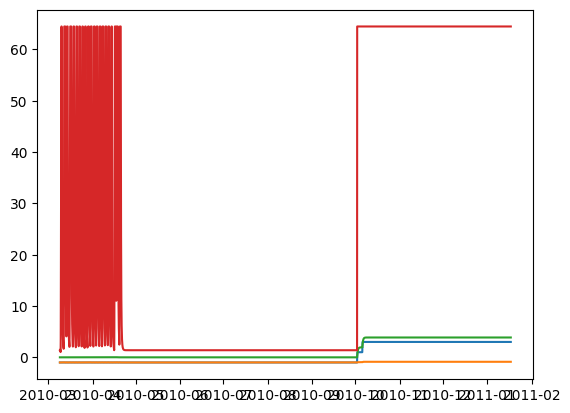

In [9]:
time, y, y_hat, error, fisher = map(viz.get, ('time', 'org', 'pred', 'errors', 'total_fisher'))

plt.plot(time, y)
plt.plot(time, y_hat)
plt.plot(time, error)
plt.plot(time, fisher)

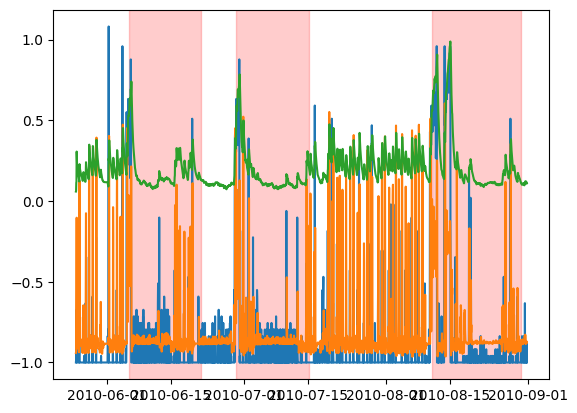

In [34]:
time, y, pred, errors = map(viz.get, ('time', 'org', 'pred', 'errors'))

plt.plot(time, y)
plt.plot(time, pred)
plt.plot(time, errors)

for _, anom in allanomalies[allanomalies['asset_id'] == 'F-8'].iterrows():
    plt.axvspan(anom.start, anom.end, color='r', alpha=.2)

In [31]:
allanomalies[allanomalies['asset_id'] == 'F-8']

,site,asset_id,start,end
0,MSL,F-8,2010-06-05 23:00:00,2010-06-21 13:00:00
1,MSL,F-8,2010-06-29 09:00:00,2010-07-15 06:00:00
2,MSL,F-8,2010-08-11 01:00:00,2010-08-30 11:00:00
